In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    TRIPS_PATH = "/content/drive/MyDrive/Project/"
else:
    TRIPS_PATH = "../../data/"
TRIPS_PATH += "nyc1.csv"

In [3]:
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [4]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt
from shapely import wkt

import h3

# Stratified Sampling

## <font color = 'blue'> Fixed Resolution and Variable Size </font>

### <font color = 'green'>- RMSE </font>

In [5]:
h3_resolution = 8

In [6]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [7]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.Pickup_longitude, trips.Pickup_latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [8]:
trips['h3'] = trips.apply(lambda x: h3.geo_to_h3(x.Pickup_latitude, x.Pickup_longitude, resolution=h3_resolution), axis = 1)

In [9]:
population_amount = (trips
                .groupby('neighborhood')
                .Total_amount
                .agg(list)
                .to_frame("Total_amount_list")
                .reset_index())  # Make a list of total amount values for each neighborhood

population_amount['Overall_amount'] = population_amount['Total_amount_list'].apply(lambda x: sum(x))  # Find the overall amount value per neighborhood
population_amount.drop('Total_amount_list', axis = 1, inplace=True)

# Normalization step
max_values = population_amount['Overall_amount'].max()
population_amount['Overall_amount'] *= 1000
population_amount['Overall_amount'] /= max_values

population_amount.sort_values(by='neighborhood', inplace=True)
population_amount.reset_index(drop=True, inplace=True)

In [10]:
def perform_test():
    error = []
    sample_size_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for sampling_frequency in sample_size_range:
        stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_amount = (stratified_sample
                    .groupby('neighborhood')
                    .Total_amount
                    .agg(list)
                    .to_frame("Total_amount_list")
                    .reset_index())  # Make a list of total amount values for each neighborhood
        random_sample_amount['Overall_amount'] = random_sample_amount['Total_amount_list'].apply(lambda x: sum(x))  # Find the overall amount value per neighborhood
        random_sample_amount.drop('Total_amount_list', axis = 1, inplace=True)
        # Normalization step
        max_values = random_sample_amount['Overall_amount'].max()
        random_sample_amount['Overall_amount'] *= 1000
        random_sample_amount['Overall_amount'] /= max_values
        for neighborhood in population_amount["neighborhood"]:
            if neighborhood not in random_sample_amount["neighborhood"].values:
                random_sample_amount.loc[len(random_sample_amount.index)] = [neighborhood, 0]
        random_sample_amount.sort_values(by='neighborhood', inplace=True)
        random_sample_amount.reset_index(drop=True, inplace=True)
        assert population_amount['neighborhood'].equals(random_sample_amount['neighborhood'])
        baseline_amount =    population_amount["Overall_amount"].values
        sampled_amount  = random_sample_amount["Overall_amount"].values
        rmse = calculate_rmse(sampled_amount, baseline_amount)
        error.append(rmse)
    H3_Performance = pd.DataFrame({'Sample Size': sample_size_range,
                                'RMSE': error})
    plt.figure()
    ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()
    return error

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac 

<Figure size 640x480 with 0 Axes>

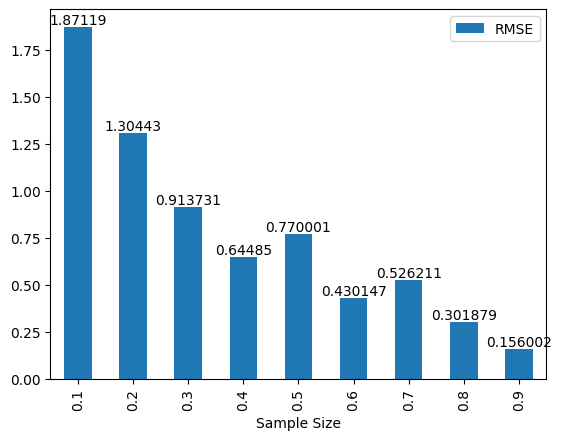

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac 

<Figure size 640x480 with 0 Axes>

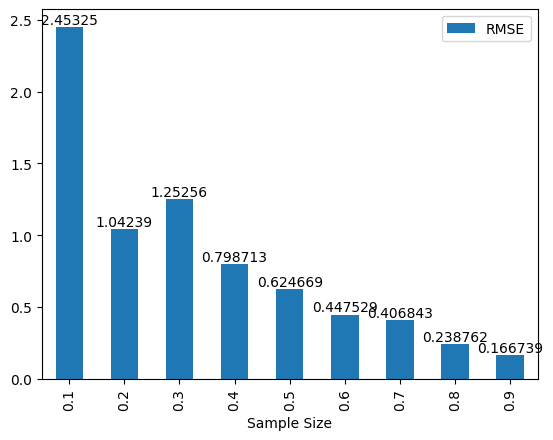

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac 

<Figure size 640x480 with 0 Axes>

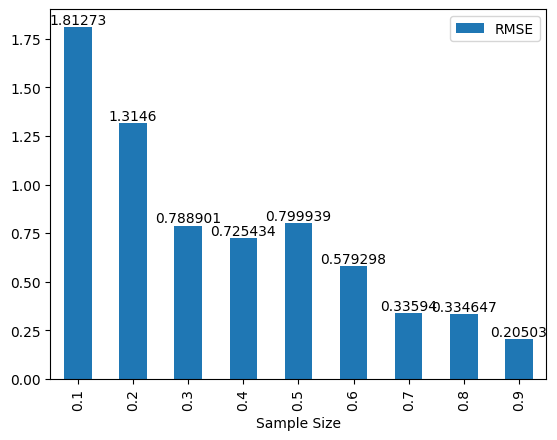

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac 

<Figure size 640x480 with 0 Axes>

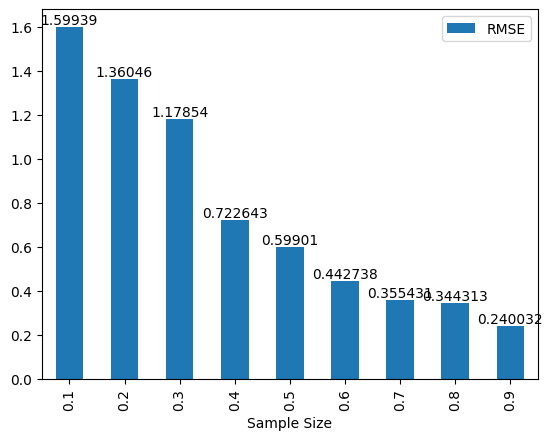

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\895960934.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('h3').apply(lambda x: x.sample(frac 

<Figure size 640x480 with 0 Axes>

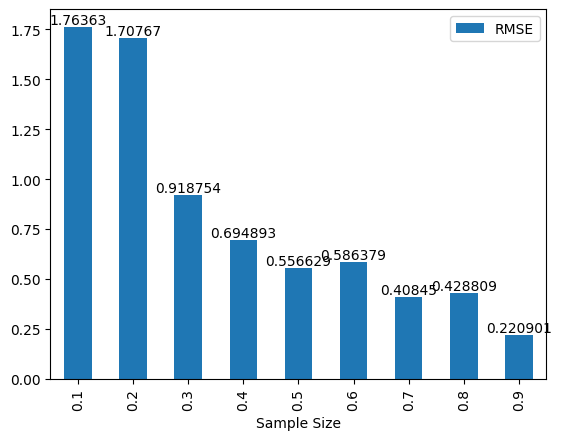

[[1.871189071648955, 1.3044292317264041, 0.9137306653374149, 0.6448497173940643, 0.7700010464463108, 0.4301472557152568, 0.5262108486514139, 0.3018789425861162, 0.15600156678032903], [2.453246831127638, 1.0423910366770797, 1.2525625655027541, 0.7987134549011314, 0.6246687125383852, 0.44752926029415246, 0.40684306903261935, 0.238761928865266, 0.16673917610567424], [1.8127262209877255, 1.3146022639188486, 0.7889012561866583, 0.7254342777593471, 0.7999385403377206, 0.5792977110271014, 0.3359400525892151, 0.3346470792769775, 0.20502957204178904], [1.59938544861353, 1.3604630290526367, 1.1785350332028766, 0.7226430528836613, 0.5990096342161909, 0.44273800589189904, 0.3554311481904711, 0.344312636197365, 0.24003248524341744], [1.7636267860569512, 1.707672505390845, 0.9187537023260455, 0.6948926605946794, 0.5566290125583052, 0.5863791307040238, 0.4084501263859407, 0.42880884218093296, 0.22090130348982503]]


In [11]:
errors = []
for _ in range(5):
    error = perform_test()
    errors.append(error)
print(errors)

We see that when the H3 resolution is fixed to 8, the error increases as the sample size decreases, but the error is still within reasonable range.

## <font color = 'blue'> Fixed Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [12]:
h3_resolution_min = 0
h3_resolution_max = 15
sampling_frequency = 0.6

In [13]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

In [14]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.Pickup_longitude, trips.Pickup_latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [15]:
population_amount = (trips
                .groupby('neighborhood')
                .Total_amount
                .agg(list)
                .to_frame("Total_amount_list")
                .reset_index())  # Make a list of total amount values for each neighborhood

population_amount['Overall_amount'] = population_amount['Total_amount_list'].apply(lambda x: sum(x))  # Find the overall amount value per neighborhood
population_amount.drop('Total_amount_list', axis = 1, inplace=True)

# Normalization step
max_values = population_amount['Overall_amount'].max()
population_amount['Overall_amount'] *= 1000
population_amount['Overall_amount'] /= max_values

population_amount.sort_values(by='neighborhood', inplace=True)
population_amount.reset_index(drop=True, inplace=True)

In [16]:
def group_by_h3(df, h3_resolution):
    df['h3'] = df.apply(lambda x: h3.geo_to_h3(x.Pickup_latitude, x.Pickup_longitude, resolution=h3_resolution), axis=1)
    return df.groupby('h3')

In [17]:
def perform_test():
    error = []
    h3_resolution = h3_resolution_min
    while h3_resolution <= h3_resolution_max:
        stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_amount = (stratified_sample
                    .groupby('neighborhood')
                    .Total_amount
                    .agg(list)
                    .to_frame("Total_amount_list")
                    .reset_index())  # Make a list of total amount values for each neighborhood
        random_sample_amount['Overall_amount'] = random_sample_amount['Total_amount_list'].apply(lambda x: sum(x))  # Find the overall amount value per neighborhood
        random_sample_amount.drop('Total_amount_list', axis = 1, inplace=True)
        # Normalization step
        max_values = random_sample_amount['Overall_amount'].max()
        random_sample_amount['Overall_amount'] *= 1000
        random_sample_amount['Overall_amount'] /= max_values
        for neighborhood in population_amount["neighborhood"]:
            if neighborhood not in random_sample_amount["neighborhood"].values:
                random_sample_amount.loc[len(random_sample_amount.index)] = [neighborhood, 0]
        random_sample_amount.sort_values(by='neighborhood', inplace=True)
        random_sample_amount.reset_index(drop=True, inplace=True)
        assert population_amount['neighborhood'].equals(random_sample_amount['neighborhood'])
        baseline_amount =    population_amount["Overall_amount"].values
        sampled_amount  = random_sample_amount["Overall_amount"].values
        rmse = calculate_rmse(sampled_amount, baseline_amount)
        error.append(rmse)
        h3_resolution += 1
    H3_Performance = pd.DataFrame({'H3 Resolution':list(range(h3_resolution_min, h3_resolution_max + 1)),
                                'RMSE': error})
    plt.figure()
    ax = H3_Performance.plot(kind='bar', x='H3 Resolution', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()
    return error

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).

<Figure size 640x480 with 0 Axes>

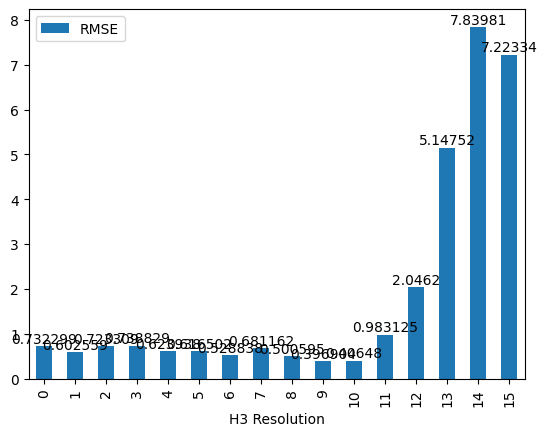

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).

<Figure size 640x480 with 0 Axes>

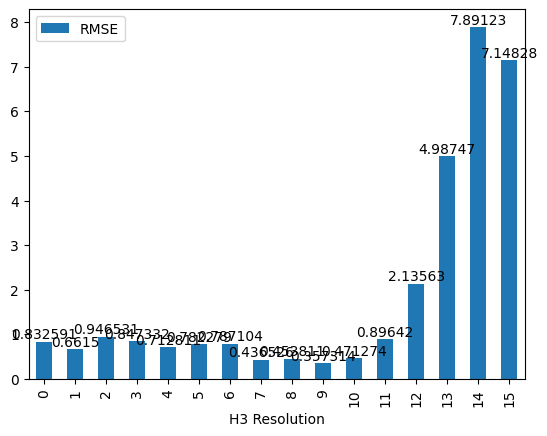

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).

<Figure size 640x480 with 0 Axes>

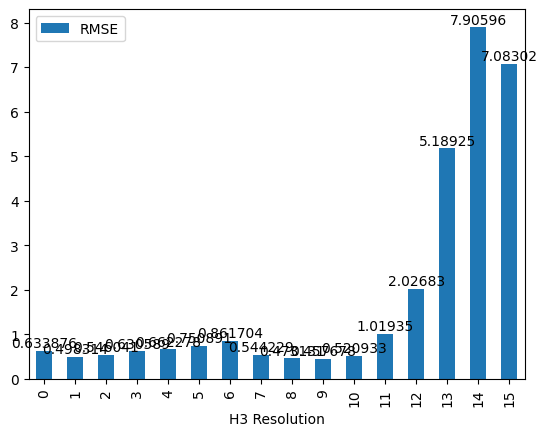

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).

<Figure size 640x480 with 0 Axes>

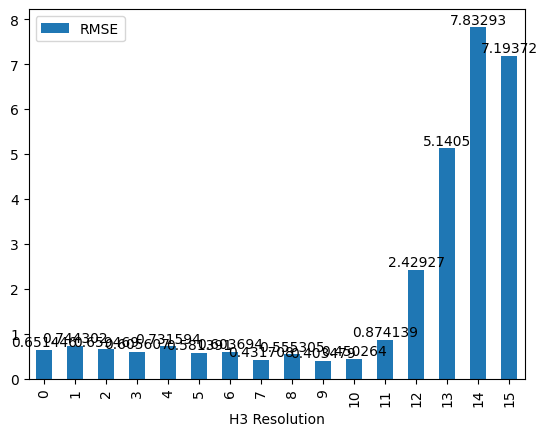

C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_23368\3805837740.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_h3(trips, h3_resolution).

<Figure size 640x480 with 0 Axes>

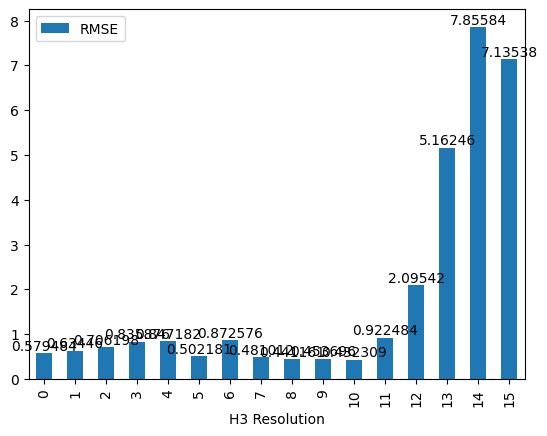

[[0.7322991478336254, 0.6025590067410087, 0.7233086817310375, 0.7388288373050393, 0.6239376226744667, 0.6165016983120832, 0.5288375695141551, 0.6811622168269293, 0.5005947848827028, 0.39690370950456155, 0.4064797450317375, 0.9831250112634405, 2.0461957010413796, 5.147517154353225, 7.839810708184865, 7.223344913552689], [0.8325910396299185, 0.6614996937484146, 0.9465314055822167, 0.8473320957346607, 0.7128108627249992, 0.7822788384557297, 0.7871035467923829, 0.4365258841505497, 0.45381065634873213, 0.3573139741541648, 0.471273856193567, 0.896420345241547, 2.1356326955115907, 4.987466999596284, 7.891231146696722, 7.148279911872888], [0.6338761269879899, 0.49831378741864674, 0.5460411800741468, 0.6305890961029601, 0.6622779684779189, 0.7508907719380029, 0.8617043952843018, 0.5442286186702748, 0.47313093785154675, 0.4576781808052942, 0.5209334174438958, 1.0193548248608062, 2.026828775083562, 5.189247978805103, 7.905963197510786, 7.083020608516094], [0.6514457929584143, 0.7443020162977001, 

In [18]:
errors = []
for _ in range(5):
    error = perform_test()
    errors.append(error)
print(errors)

We see that with H3 resolutions >= 11, the error increases considerably when using 60% as the sample size for stratified sampling using H3 when it comes to reducing the dataset size while still retaining the same information on a neighborhood-level. As for other resolutions, the error remains low.